In [3]:
import numpy as np
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

## Create Database Connection

In [4]:
db = CurlingDB()

# Some Plots

## Stone Position Testing

In [5]:
stone_position_cmd = """
SELECT x, y, colour
FROM Stone
"""
db.execute_query(stone_position_cmd)
all_stone_positions = pd.DataFrame(db.cursor.fetchall(), columns=['x', 'y', 'colour'])
all_stone_positions.head()

,x,y,colour
0,0.5,451,red
1,0.5,-63,yellow
2,3.0,-33,red
3,1.0,451,red
4,-1.0,-80,yellow


/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 16 rows containing non-finite values.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 15 rows containing missing values.


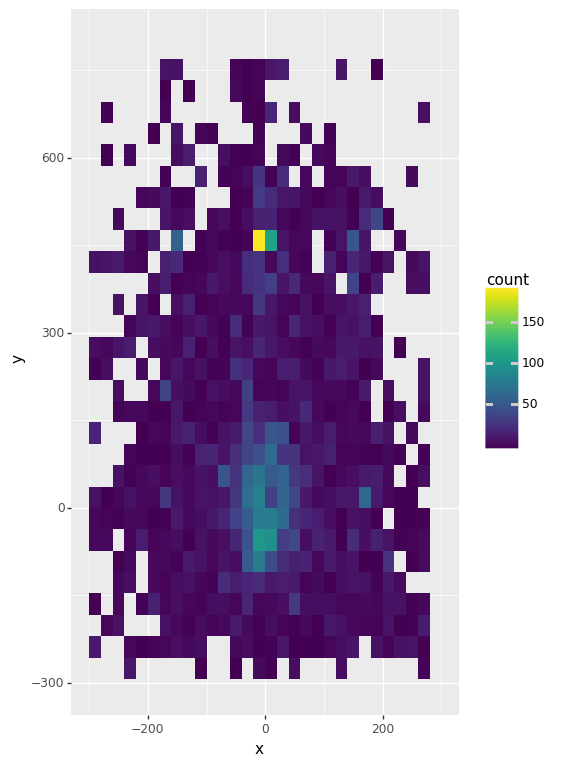

<ggplot: (687874298)>

In [6]:
size = 5
(gg.ggplot(all_stone_positions, gg.aes(x='x', y='y', group='colour'))
     + gg.geom_bin_2d()
     + gg.scale_x_continuous(limits=(-300, 300))
     + gg.scale_y_continuous(limits=(-300, 800))
    #  + gg.scale_colour_manual(values=['red', 'yellow'])
     + gg.theme(figure_size=(size, size*((800 + 300)/(600))))
     )

## Match Summary

In [7]:
match_summary_cmd = """
SELECT m.team_1, m.team_2, e.num, e.hammer_colour, e.direction, p.frame_num, s.x, s.y, s.colour
FROM Stone s
JOIN Position p
ON s.position_id = p.position_id
JOIN End e
ON p.end_id = e.end_id
JOIN Match m
ON e.match_id = m.match_id
WHERE m.match_id = ?
"""
db.execute_query(match_summary_cmd, (1,))
match_summary = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'x', 'y', 'colour'])
print(match_summary.shape)
match_summary.head()

(492, 9)


,team_1,team_2,end_num,hammer_colour,play_direction,frame_num,x,y,colour
0,CHN,SUI,1,yellow,down,0,0.5,451,red
1,CHN,SUI,1,yellow,down,0,0.5,-63,yellow
2,CHN,SUI,1,yellow,down,1,3.0,-33,red
3,CHN,SUI,1,yellow,down,1,1.0,451,red
4,CHN,SUI,1,yellow,down,1,-1.0,-80,yellow


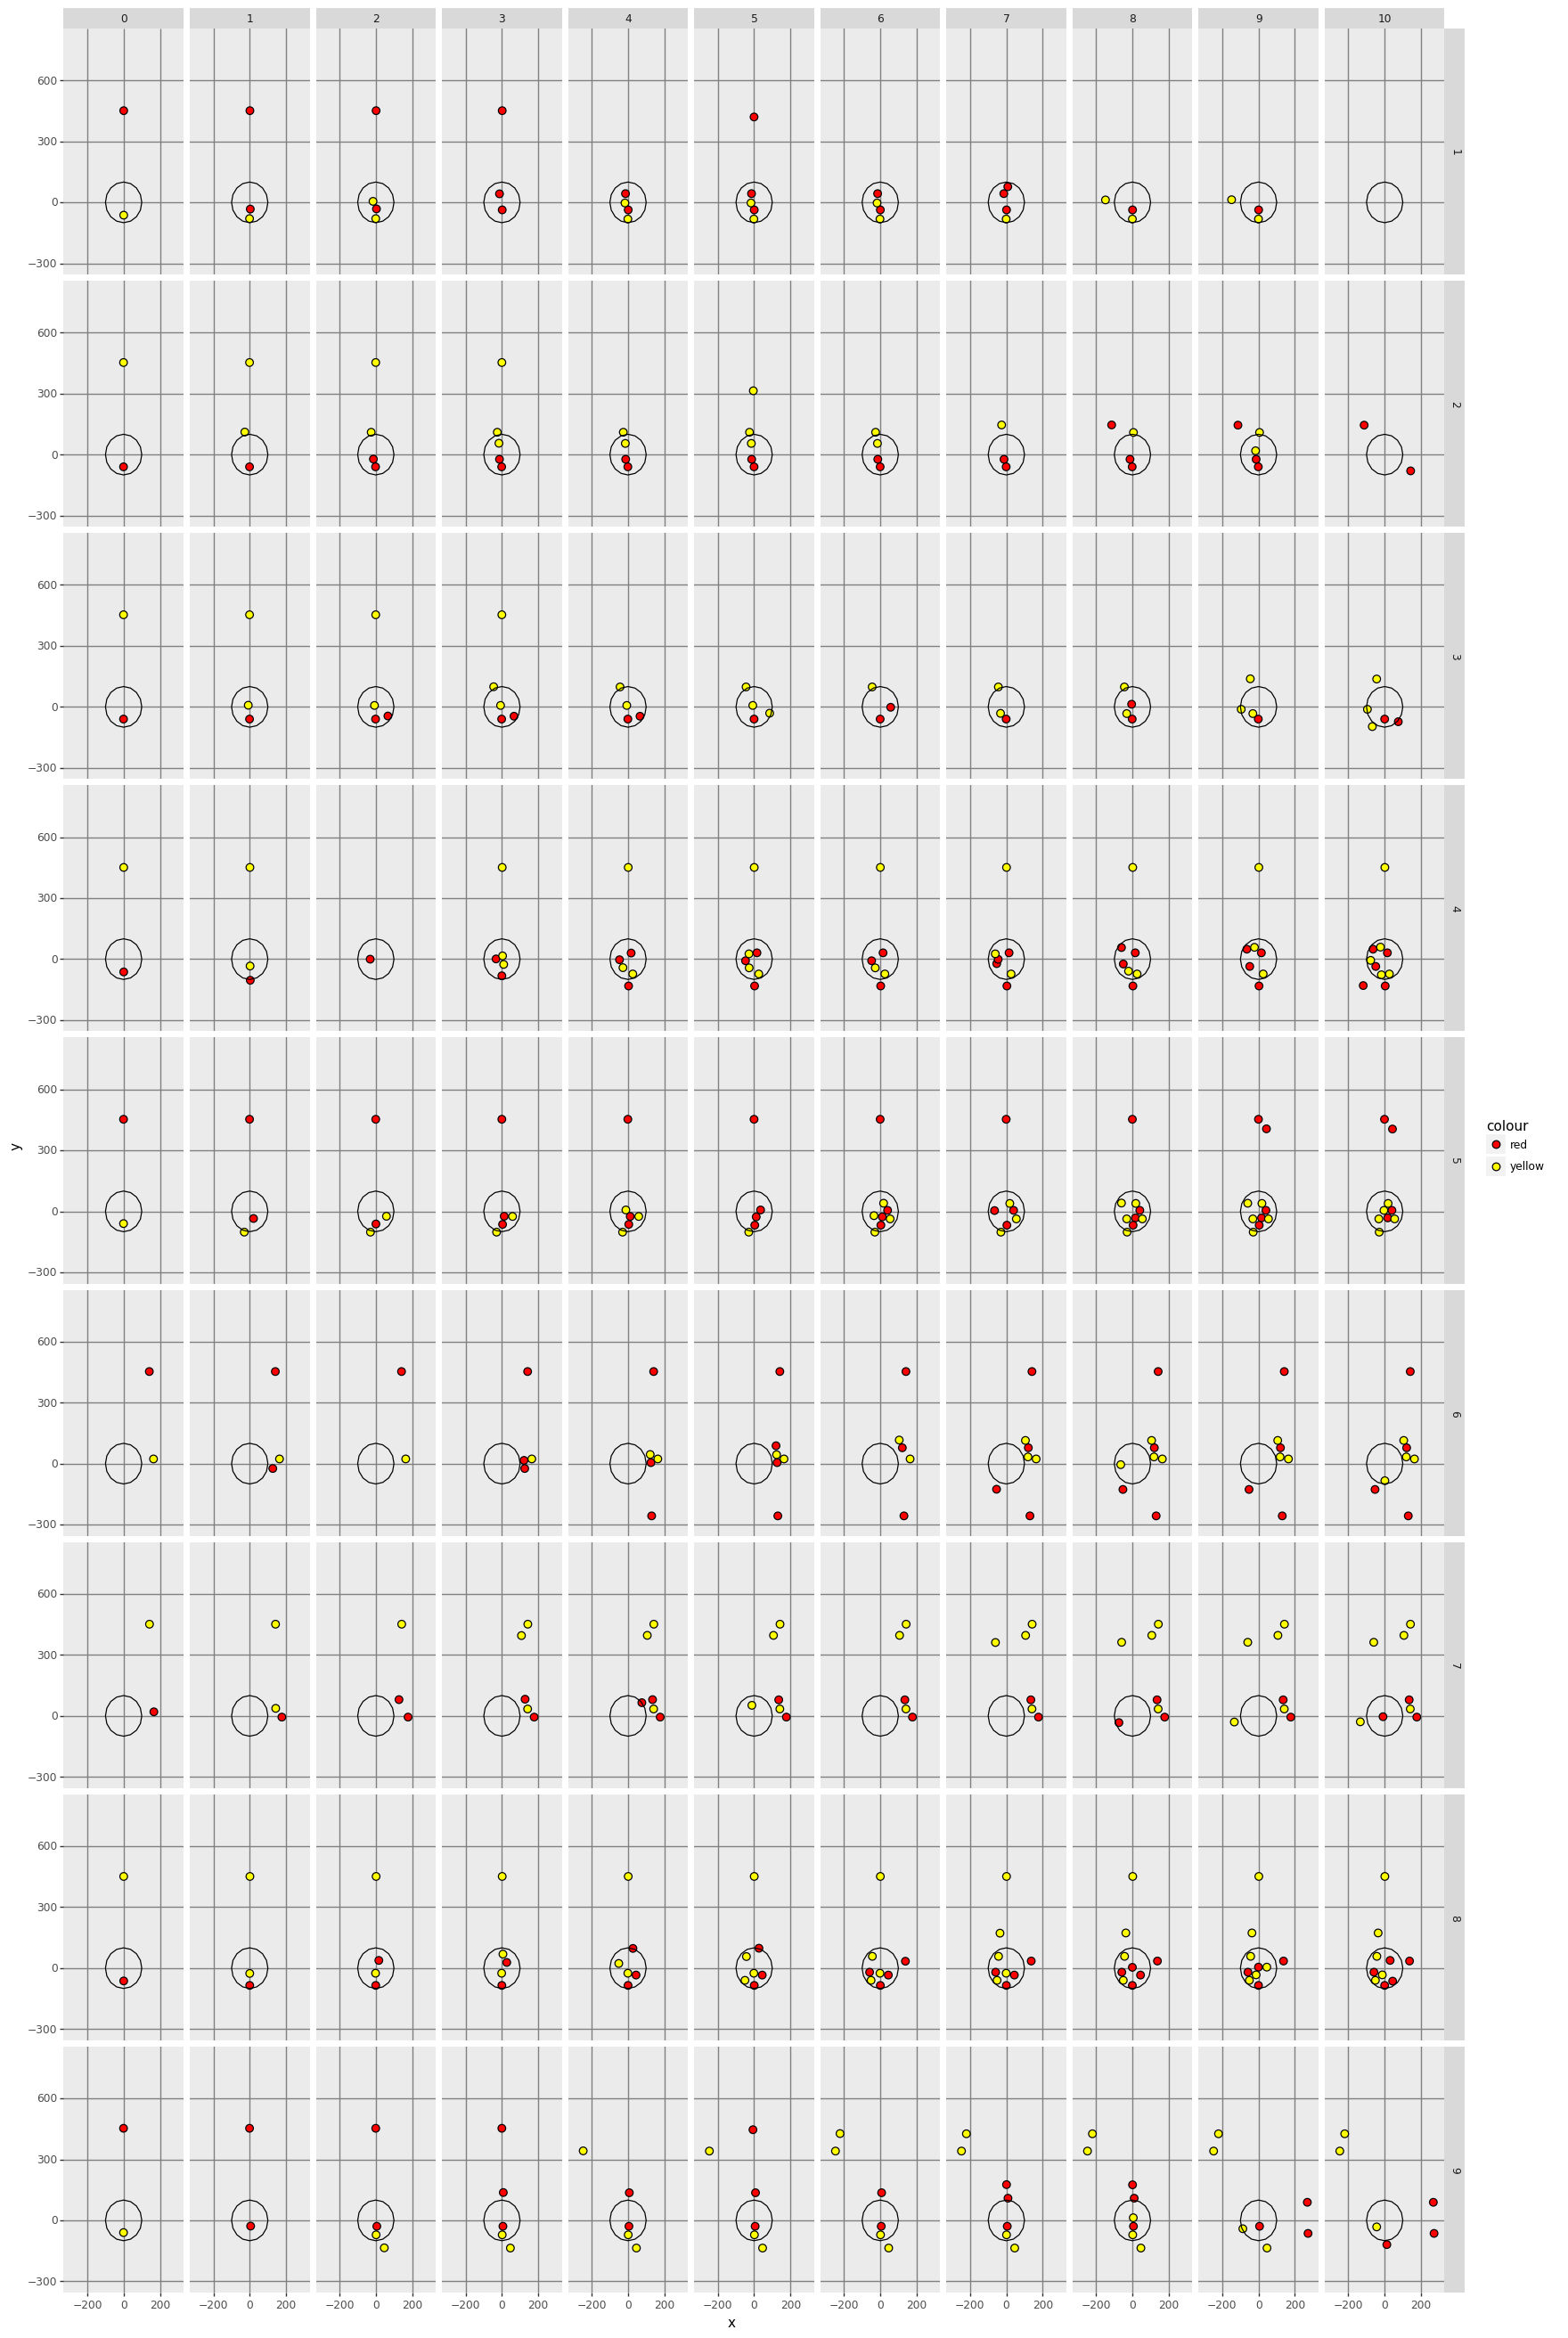

<ggplot: (688649235)>

In [15]:
size = 2
inc = np.pi / 8
circle_range_x = 100 * np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = 100 * np.sin(np.arange(0, 2 * np.pi + inc, inc))
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour'))
    + gg.geom_point(size=3)
    + gg.annotate(geom='path', x=circle_range_x, y=circle_range_y)

    + gg.facet_grid('end_num ~ frame_num')

    + gg.scale_x_continuous(limits=(-300, 300))
    + gg.scale_y_continuous(limits=(-300, 800))
    + gg.scale_fill_manual(values=['red', 'yellow'])
    + gg.theme(figure_size=(size * 10, size * 9 * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))

    # + pe.background_colour(colour='#000000')
    + pe.remove_grid(minor=True)
 )